In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import modules.experiment.events as expevents
import modules.experiment.fov as expfov
import modules.utils as utils
import modules.plots.experimental_data as expplots

from modules_reloader import reloader

relmod = reloader(expevents, expfov, utils, expplots)

In [3]:
processor = expevents.EventProcessor(N=45, verbosity=3, load_rir=False, min_signal_significance=4)
L = 10
N = processor.N

In [4]:
try:
    ldfs
except NameError:
    ldfs = dict()


In [5]:
event_id = 10675
event = expevents.Event(event_id)

In [6]:
fov = expfov.PmtFov.for_event(event_id)

In [7]:
axis_x, axis_y, axis_theta, axis_phi = processor.read_eas_geometry(event.id_)

In [8]:
def project_on_shower_plane(x, y, theta, phi):
    r_d = np.sqrt(x ** 2 + y ** 2)
    phi_d = np.arctan(y / x)
    phi_d[x < 0] += np.pi
    phi_d[np.logical_and(x > 0, y < 0)] += 2 * np.pi

    eta = np.pi / 2 - (phi - phi_d)
    x_pl = - r_d * np.cos(eta)
    y_pl = - r_d * np.sin(eta) * np.cos(theta)
    return x_pl, y_pl

In [9]:
axis_x_proj, axis_y_proj = project_on_shower_plane(np.array([axis_x]), np.array([axis_y]), axis_theta, axis_phi)

In [10]:
fov_x_proj, fov_y_proj = project_on_shower_plane(fov.x, fov.y, axis_theta, axis_phi)

fov_x_proj -= axis_x_proj
fov_y_proj -= axis_y_proj

(-154.08587789237237,
 224.46541098202974,
 -147.56212715936758,
 214.50908152943487)

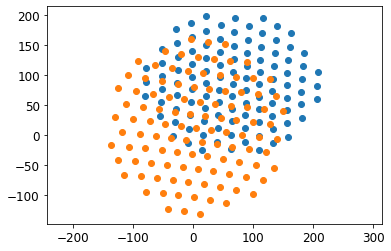

In [11]:

fig, ax = plt.subplots()
# ax.scatter(fov_x_proj + axis_x_proj, fov_y_proj + axis_y_proj)
ax.scatter(fov_x_proj, fov_y_proj)
ax.scatter(fov.x, fov.y)
ax.axis('equal')


In [12]:
from scipy.interpolate import griddata
from tqdm import trange

FOV_proj = np.zeros((109, fov.side, fov.side))

for i_ch in trange(109):
    fov_grid = fov.grid()
    x_ch, y_ch = np.meshgrid(fov_grid, fov_grid)
    x_ch = x_ch.flatten()
    y_ch = y_ch.flatten()
    x_ch_proj, y_ch_proj = project_on_shower_plane(x_ch, y_ch, axis_theta, axis_phi)
    FOV_ch = np.squeeze(fov.FOV[i_ch, :, :]).flatten()
    FOV_proj[i_ch, :, :] = griddata(
        utils.concat_vectors_as_cols(x_ch_proj, y_ch_proj),
        FOV_ch,
        utils.concat_vectors_as_cols(x_ch, y_ch),
        method='cubic',
        fill_value=0.0,
    ).reshape(fov.side, fov.side)


100%|██████████| 109/109 [00:05<00:00, 19.87it/s]


In [13]:
fov_proj = expfov.PmtFov(
    FOVc=np.concatenate((np.expand_dims(fov_x_proj, 1), np.expand_dims(fov_y_proj, 1)), axis=1),
    FOV=FOV_proj
)

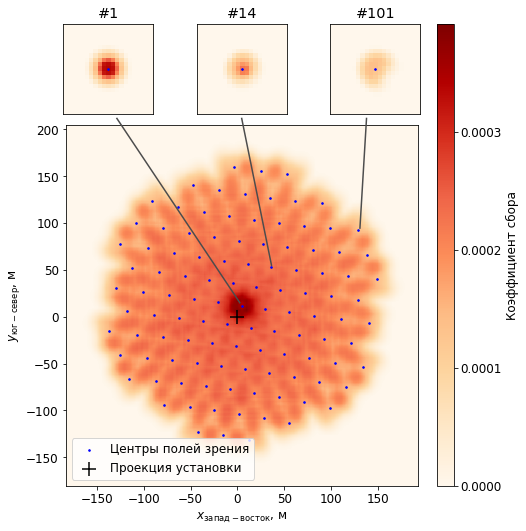

(<Figure size 504x612 with 5 Axes>,
 <AxesSubplot:xlabel='$x_{{\\mathrm{{запад-восток}}}}$, м', ylabel='$y_{{\\mathrm{{юг-север}}}}$, м'>)

In [14]:
relmod()
cut_edges = 3
expplots.plot_fov(fov, cut_edges=cut_edges)

In [32]:
relmod()

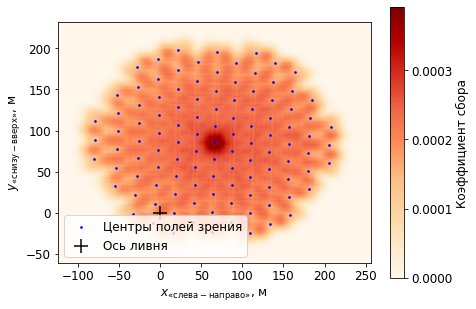

In [35]:
from modules.plots._shared import _save_or_show

fig, ax = plt.subplots(figsize=(7, 5))

expplots.plot_fov(
    fov_proj,
    cut_edges=cut_edges,
    x_label='$x_{{\\mathrm{{«слева-направо»}}}}$, м',
    y_label='$y_{{\\mathrm{{«снизу-вверх»}}}}$, м',
    origin_label='Ось ливня',
    draw_arrows=True,
    ax_for_central_img=ax,
    arrows_finetuning=np.array([0, -40]),
)

# _save_or_show('projected-pmt-fov')

In [171]:
r_means = np.zeros(109)
r_stds = np.zeros(109)

def radial(xy):
    if len(xy.shape) == 1:
        xy = xy.reshape(1, xy.size)
    return np.sqrt(xy[:, 0] ** 2 + xy[:, 1] ** 2)

for i_ch in range(109):
    fov_grid = fov_proj.grid()
    xx, yy = np.meshgrid(fov_grid, fov_grid)
    xy = utils.concat_vectors_as_cols(xx.flatten(), yy.flatten())
    fovdata = np.squeeze(fov_proj.FOV[i_ch, :, :]).reshape(xx.size, 1)
    mean_xy = np.sum(fovdata * xy, axis=0) / np.sum(fovdata)

    r_mean = radial(fov_proj.FOVc[i_ch, :] + mean_xy)[0]
    fovdata = fovdata.flatten()
    r_std = np.sqrt(np.sum(fovdata * (radial(fov_proj.FOVc[i_ch, :] + xy) - r_mean) ** 2, axis=0) / np.sum(fovdata))

    r_means[i_ch] = r_mean
    r_stds[i_ch] = r_std

In [172]:
n_samples, has_signal = processor.read_reconstruction_marginal_sample_per_channel(event.id_, parameter='n')
significant = processor.read_signal_significances(event.id_)[has_signal] > processor.min_signal_significance
_, _, inplane = processor.reconstruct_eas_angle(event)

45 points with significance>4
35 points left in fit after exclusion


In [173]:
r_means = r_means[has_signal][significant][inplane]
r_stds = r_stds[has_signal][significant][inplane]

n_means = n_samples.mean(axis=0)[significant][inplane]
n_stds = n_samples.std(axis=0)[significant][inplane]

In [174]:
ldfs[event.id_] = (r_means, n_means, n_stds, r_stds)

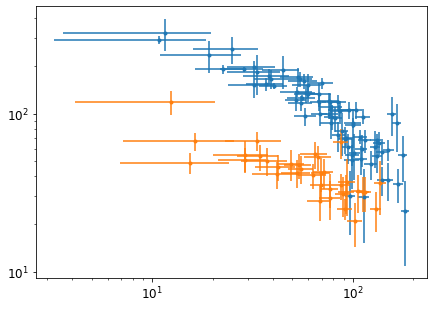

In [175]:
fig, ax = plt.subplots(figsize=(7, 5))

for ev_id, ldf in ldfs.items():
    r_means, n_means, n_stds, r_stds = ldf
    ax.errorbar(r_means, n_means, yerr=n_stds, xerr=r_stds, fmt='.', label=f'{ev_id}')
ax.set_yscale('log')
ax.set_xscale('log')
